#Libraries

In [ ]:
!pip install biosppy catboost neurokit2

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import biosppy.signals.ecg as ecg
import neurokit2 as nk
from scipy import stats, signal

# Loading data

The flipped data is stored in polybox (The access is very fast, like it)


*   X_train_inverted https://polybox.ethz.ch/index.php/s/HISVG3Mbnykdhv7
*   X_test_inverted https://polybox.ethz.ch/index.php/s/rK4XhWE8ytsfHuh



In [4]:
#Loading data
X_train_path = 'drive/MyDrive/AML/task2/X_train.csv'
Y_train_path = 'drive/MyDrive/AML/task2/y_train.csv'
X_test_path = 'drive/MyDrive/AML/task2/X_test.csv'

X = pd.read_csv(X_train_path).drop(columns='id')
y = pd.read_csv(Y_train_path).drop(columns='id')
X_test = pd.read_csv(X_test_path).drop(columns='id')


# Exploration & Play

## Class signal extraction function
This function extracts n data points from each class to experiment with. As of now it takes the first n data points in the series of each class.

In [5]:
def class_data_extraction(X,y,n = 5):
  """ Use this function to pick out n datapoints of each class.

  Returns dataframes with X and corresponding y values, however, 
  beware that the indexes are labeled with datapoint id.
  """

  X_copy = X.copy()
  y_copy = y.copy()

  y_out = pd.DataFrame(columns = y_copy.columns)
  X_out = pd.DataFrame(columns = X_copy.columns)

  
  # Finds the n first appering datapoints in the data set from each class.
  for class_ in [0,1,2,3]:
    y_class = y_copy[y_copy['y']==class_]
    for i in range(0,n):
      y_out = y_out.append(y_class.iloc[i])
      X_out = X_out.append(X_copy.iloc[y_out.index[-1]])

  return X_out, y_out

# Use the function above to pick out values.
X_sample, y_sample = class_data_extraction(X,y,n=2)

## Plotting ECG of different classes.

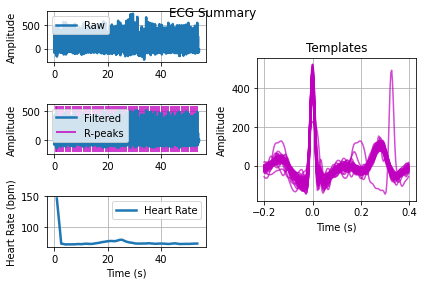

This is a hearbeat of class 0.


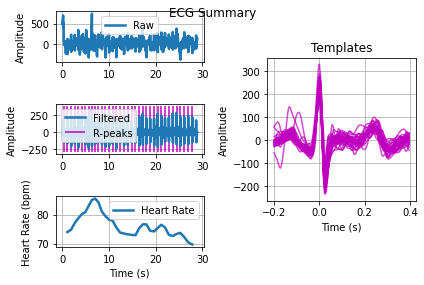

This is a hearbeat of class 0.


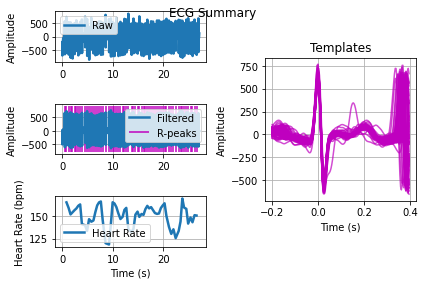

This is a hearbeat of class 1.


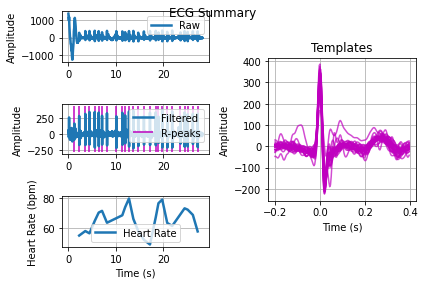

This is a hearbeat of class 1.


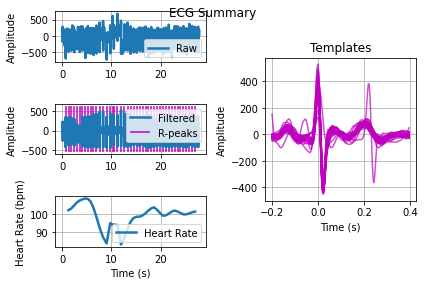

This is a hearbeat of class 2.


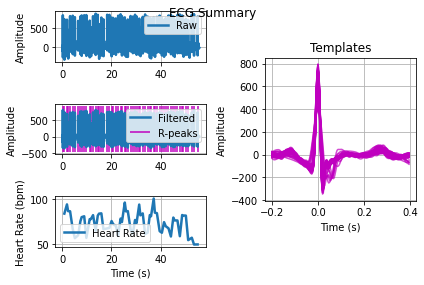

This is a hearbeat of class 2.


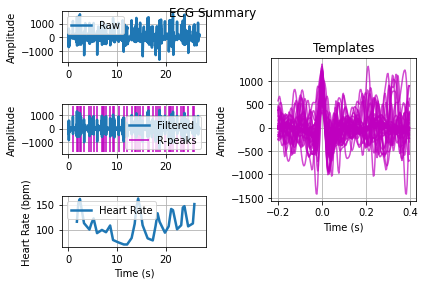

This is a hearbeat of class 3.


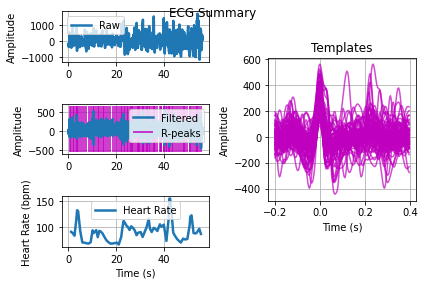

This is a hearbeat of class 3.


In [6]:
# Simply plot the signals with biosppy
# Choose how many of each you want to plot with n.
n = 2
X_sample, y_sample = class_data_extraction(X,y,n)
for i in range(len(X_sample)):
  sig = X_sample.iloc[i]
  sig = sig[~sig.isna()]
  ret = ecg.ecg(signal = sig,sampling_rate = 300,show=True)
  print('This is a hearbeat of class ' + str(y_sample.iloc[i]['y']) + '.')


## Plotting autocorr for different classes.
Plotting the autocorr in order to determine what lags to include as features in the model.

Findings:
 

*   High correlation for low lags (as could be expected) and it goes down quite fast.
*   Seems to be a spike on many between 200-400, which is reasonable as this would be the next R-peak.

Proposal: Strong peaks at 200-400 indicates heart beating regularly, lower peaks that it beat irregularly, could this be used?. 



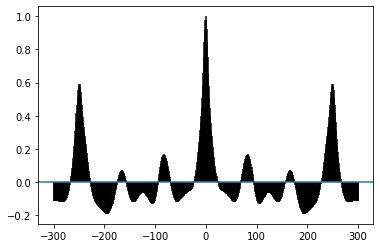

This is a hearbeat of class 0.


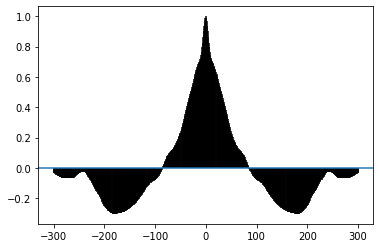

This is a hearbeat of class 0.


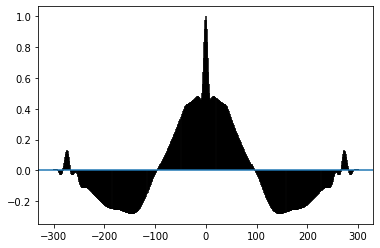

This is a hearbeat of class 0.


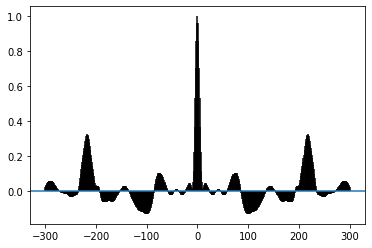

This is a hearbeat of class 0.


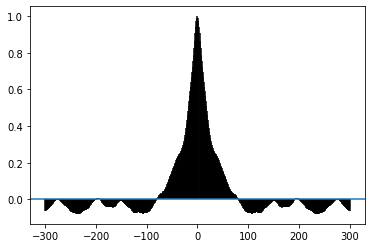

This is a hearbeat of class 0.


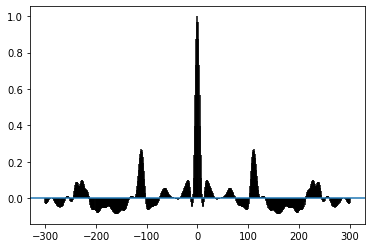

This is a hearbeat of class 1.


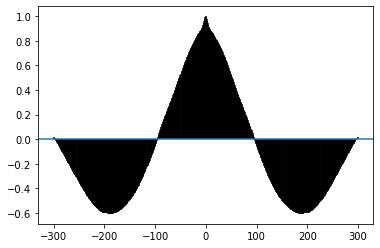

This is a hearbeat of class 1.


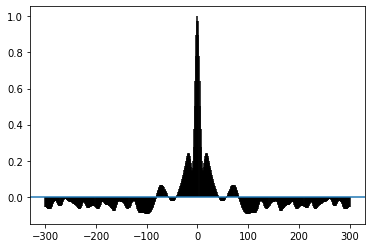

This is a hearbeat of class 1.


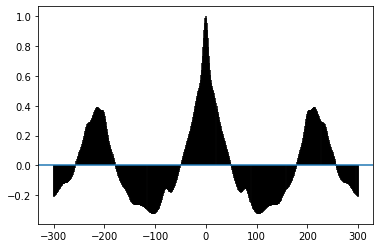

This is a hearbeat of class 1.


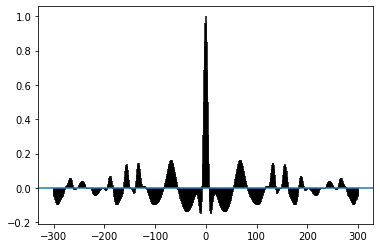

This is a hearbeat of class 1.


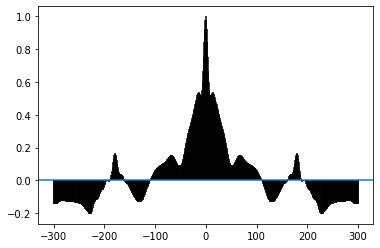

This is a hearbeat of class 2.


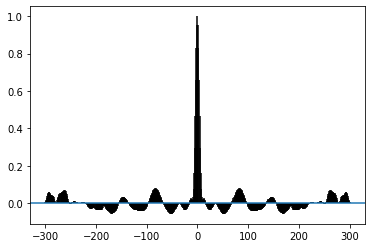

This is a hearbeat of class 2.


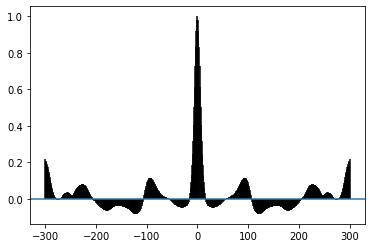

This is a hearbeat of class 2.


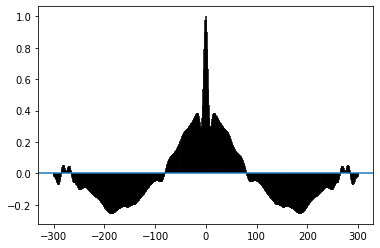

This is a hearbeat of class 2.


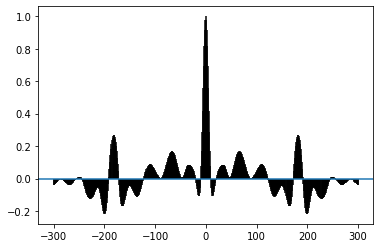

This is a hearbeat of class 2.


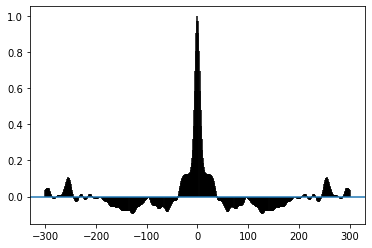

This is a hearbeat of class 3.


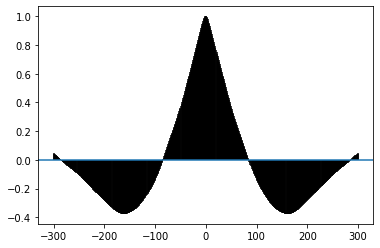

This is a hearbeat of class 3.


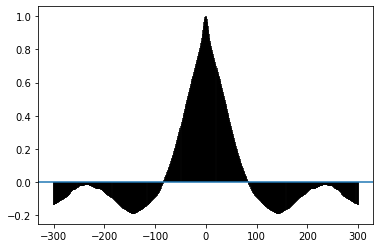

This is a hearbeat of class 3.


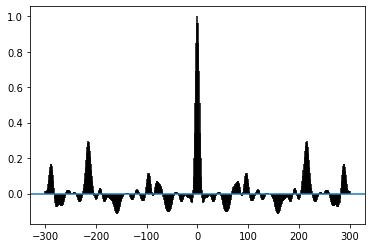

This is a hearbeat of class 3.


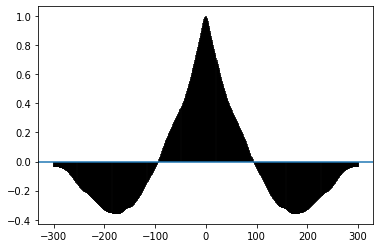

This is a hearbeat of class 3.


In [7]:
n = 5 # Number of plots per signaltype.
X_sample, y_sample = class_data_extraction(X,y,n)

for i in range(len(X_sample)):
  sig = X_sample.iloc[i]
  sig = sig[~sig.isna()]
  plt.figure()
  plt.acorr(sig, maxlags = 300)
  plt.show()
  print('This is a hearbeat of class ' + str(y_sample.iloc[i]['y']) + '.')


## Plotting FFT for different classes

Findings
Here as well it is hard to say which frequency peaks that could be relevant. However, I would say that the most reasonable, or "unbiased", way to pick out features is to just choose a couple of frequencies between 0-100 and use the amplitudes as a feature.

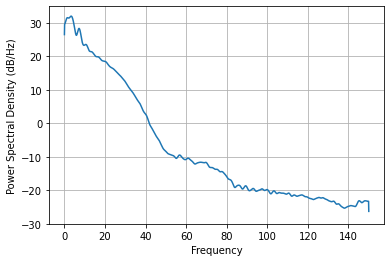

1501
[3.45017608e-30 4.14297761e+02 2.55611740e+01 ... 9.44282588e-04
 1.23660382e-03 2.77777778e-03]
This is a hearbeat of class 0.


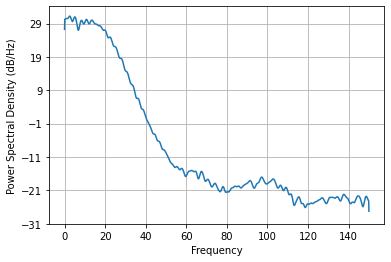

1501
[2.18427381e-29 6.42091307e+02 2.81643534e+03 ... 5.04278167e-02
 3.14209817e-02 8.02777778e-03]
This is a hearbeat of class 1.


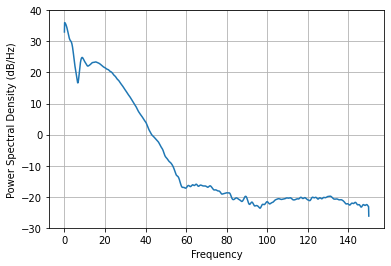

1501
[2.01657586e-28 1.25196492e+03 5.20625564e+03 ... 6.20006990e-03
 5.37680153e-03 1.08900000e-02]
This is a hearbeat of class 2.


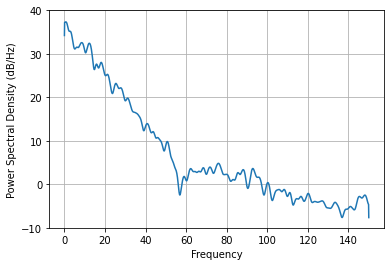

1501
[4.44839352e-28 2.59178352e+03 4.87735617e+02 ... 1.33218474e-01
 2.71028720e-02 6.18351111e-01]
This is a hearbeat of class 3.


In [8]:
n = 1
X_sample, y_sample = class_data_extraction(X,y,n)


## 
for i in range(len(X_sample)):
  sig = X_sample.iloc[i].fillna(value = 0)        #Zero-padding gives better resolution to the fourier transform.
  plt.figure()

  # The Pxx is a vector of pad_to/2+1 values for the Power Spectral density. Pick from this to find certain frequencies.
  Pxx,_ = plt.psd(sig,Fs=300,pad_to=3000)
  plt.show()

  freq, Pxx2 = signal.periodogram(sig, fs = 300, nfft = 3000)

  print(len(freq))
  print(Pxx2)


  print('This is a hearbeat of class ' + str(y_sample.iloc[i]['y']) + '.')


# Feature extract functions
They should return a row for each signal.

Later we just 

- concat them a single row
- throw away features that's NaN everywhere (maybe impute in other cases)
- feeding all of them to our model

## Extract_ecg

In [19]:
def ecg_stat(pos):
  """ Returns a list of stats for a given list of peak-amplitudes.

  Returns mean, median, variance, min, max, mode. (6)

  """


  if len(pos) == 0:
    return [np.nan for i in range(6)]
  return np.mean(pos), np.median(pos), np.var(pos), np.min(pos), np.max(pos), stats.mode(pos)[0][0]

def extract_ecg(sig):
  """ Returns 61 features from ecg data.

  Input is an ecg-signal stripped of nan-values from ends. 
  It is assumed that the signal does not contain missing values 

  Features returned:
  - Sum of NaN-values for p,q,r,s,t,p-onset,t-offset. (7)
  - Stats from ecg_stats on distances p-onset to T, P to R, Q to S, S to T, S to T_offset. (6x5=30)
  - Stats of amplitudes of Q, R and S. (6x3=18)
  - Stats of distances between R - peaks. (6x1=6)
  
  """
  
  cleaned_sig = nk.ecg_clean(sig, sampling_rate = 300)
  signals, info = nk.ecg_peaks(cleaned_sig, sampling_rate=300)
  
  try:
    signals, waves_sanitized = nk.ecg_delineate(cleaned_sig, info["ECG_R_Peaks"], sampling_rate=300, method="peak")
  except:
    print('ECG_Delineate FAIL')
    return [np.nan for i in range(60)]

  r_peaks = np.array(info["ECG_R_Peaks"])
  p_peaks, q_peaks, s_peaks, t_peaks, p_onsets, t_offsets = np.array(waves_sanitized['ECG_P_Peaks']), np.array(waves_sanitized['ECG_Q_Peaks']),\
                                                      np.array(waves_sanitized['ECG_S_Peaks']), np.array(waves_sanitized['ECG_T_Peaks']),\
                                                      np.array(waves_sanitized['ECG_P_Onsets']), np.array(waves_sanitized['ECG_T_Offsets'])
  
  # many nan here, maybe a measure of inconsistency
  p_peak_nan = sum(np.isnan(p_peaks))
  q_peak_nan = sum(np.isnan(q_peaks))
  s_peak_nan = sum(np.isnan(s_peaks))
  t_peak_nan = sum(np.isnan(t_peaks))
  p_onset_nan = sum(np.isnan(p_onsets))
  t_offset_nan = sum(np.isnan(t_offsets))
  
  # list of distance of important points
  important_point_list = [r_peaks, p_peaks, s_peaks, t_peaks, p_onsets, t_offsets]
  max_length = np.max([len(x) for x in important_point_list])

  if len(p_onsets) < max_length:
    p_onsets = np.pad(p_onsets, (max_length - len(p_onsets), 0), 'constant', constant_values=(0, 0))
  if len(t_offsets) < max_length:
    t_offsets = np.pad(t_offsets, (0, max_length - len(t_offsets)), 'constant', constant_values=(len(sig), len(sig)))
  
  # Calculating distances
  dis_P_on_R = r_peaks - p_onsets
  dis_P_R = r_peaks - p_peaks
  dis_QRS = s_peaks - q_peaks
  dis_S_T = t_peaks - s_peaks
  dis_S_T_off = t_offsets - s_peaks
  
  # Stripping nan-values
  dis_P_on_R = dis_P_on_R[~np.isnan(dis_P_on_R)]
  dis_P_R = dis_P_R[~np.isnan(dis_P_R)]
  dis_QRS = dis_QRS[~np.isnan(dis_QRS)]
  dis_S_T = dis_S_T[~np.isnan(dis_S_T)]
  dis_S_T_off = dis_S_T_off[~np.isnan(dis_S_T_off)]
  
  # Stats on distances
  stat_P_on_R = ecg_stat(dis_P_on_R)
  stat_P_R = ecg_stat(dis_P_R)
  stat_QRS = ecg_stat(dis_QRS)
  stat_S_T = ecg_stat(dis_S_T)
  stat_S_T_off = ecg_stat(dis_S_T_off)
  
  # lists of QRS amplitude
  Q_amp = cleaned_sig[q_peaks[~np.isnan(q_peaks)].astype(int)]
  R_amp = cleaned_sig[r_peaks]
  S_amp = cleaned_sig[s_peaks[~np.isnan(s_peaks)].astype(int)]
  
  # Stats on amplitude
  stat_Q_amp = ecg_stat(Q_amp)
  stat_R_amp = ecg_stat(R_amp)
  stat_S_amp = ecg_stat(S_amp)

  # list of R peak distance
  rpeak_distances = np.diff(r_peaks)
  stat_rpeak_dis = ecg_stat(rpeak_distances)


  return np.concatenate([(p_peak_nan, q_peak_nan, s_peak_nan, t_offset_nan, p_onset_nan, t_offset_nan),\
                          stat_P_on_R, stat_P_R, stat_QRS, stat_S_T, stat_S_T_off,\
                          stat_Q_amp, stat_R_amp, stat_S_amp,\
                          stat_rpeak_dis])

## Extract hrv

In [20]:
def hrv_stat(pos):
  """ Returns stats info of a hrv-set.

  Returns mean, median, variance, min, max, mode. (6)

  """
  return np.mean(pos), np.median(pos), np.var(pos), np.min(pos), np.max(pos), stats.mode(pos)[0][0]

# Using heart beat to get hrv info
# about 29 feature in hrv
def extract_hrv(sig):
  """ Gives a bunch of hrv features

  """

  sig = sig.to_numpy()
  # heart rate change
  sig = nk.ecg_clean(sig, sampling_rate=300)
  rpeaks, info = nk.ecg_peaks(sig, sampling_rate=300)
  rate = nk.ecg_rate(rpeaks, sampling_rate=300, desired_length=len(sig))
  rate_change = np.diff(rate)
  stat_rate_change = hrv_stat(rate_change)
  # nk hrv data
  # For some signals this didn't work, thus the try-except.
  try:
    freq_domain = nk.hrv_frequency(rpeaks, sampling_rate=300).to_numpy().reshape(-1)
  except:
    freq_domain = np.array([np.nan for i in range(9)]).reshape(-1)
  try:
    time_domain = nk.hrv_time(rpeaks, sampling_rate=300).to_numpy().reshape(-1)
  except:
    time_domain = np.array([np.nan for i in range(20)]).reshape(-1)
  try:
    nonliner_domain = nk.hrv_nonlinear(rpeaks, sampling_rate=300).to_numpy().reshape(-1)
  except:
    nonliner_domain = np.array([np.nan for i in range(43)]).reshape(-1)
  hrv_indices = np.concatenate((stat_rate_change, freq_domain, time_domain, nonliner_domain), axis=None)
  return hrv_indices

##Extract rrv

In [21]:
# Using nk.ecg_rsp to get rsp data
# Then analyze it with rrv
# about 20 feature about rrv
def extract_rrv(sig):
  """
  Problem: To many null values(maybe 50%, mostly type1 and type3 are NaN, maybe a good judgement by itself). 
  Use if predictions is improved.
  """

  sig = sig.to_numpy()
  # Get RSP
  sig = nk.ecg_clean(sig, sampling_rate=300)
  rpeaks, info = nk.ecg_peaks(sig, sampling_rate=300)
  ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=300, desired_length=len(sig))
  rsp = nk.ecg_rsp(ecg_rate, sampling_rate=300)
  # Process RSP
  cleaned = nk.rsp_clean(rsp, sampling_rate=300)
  try:
    signal, info = nk.rsp_process(cleaned, 300)
    rrv = nk.rsp_intervalrelated(signal, 300).to_numpy().reshape(-1)
  except:
    rrv = np.array([np.nan for i in range(25)]).reshape(-1)
  return rrv

## Extract Autocorr

In [22]:
def extract_autocorr(sig, list_lag = None):
  """ Returns autocorrelation of lags specified in list_lag.

  If list_lag is not specified, lags will be 10,20,30,40,50 and every tenth value from 200 to 400.
  These choices are based on observations and hypotheses about what information the autocorr will give us according to 
  earlier experimentation.

  """

  if list_lag is None:
    list_lag = [10,20,30,40,50,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400]

  df = pd.DataFrame()
  for lag in list_lag:
    df['lag = ' + str(lag)] = [sig.autocorr(lag)]
  return df.to_numpy().reshape(-1)

### Testing autocorr func

In [23]:
# Simple test-function to see that the output is as expected.
X_sample,_ = class_data_extraction(X,y,n=1)
list_lag = [2,5,10,100]
autocorr_test = []
for i in range(len(X_sample)):
  sig = X_sample.iloc[i].dropna()
  autocorr_test.append(extract_autocorr(sig,list_lag))

pd.DataFrame(autocorr_test[0])


,0
0,0.924743
1,0.658171
2,0.350325
3,-0.110401


## Extract frequency representation (fft)

In [24]:
def extract_fft(sig, frequency_list = None):
  """ Returns features containing amplitudes at frequences specified in frequency_list.

  If no frequencies are specified, returns 14 values in equal spread of frequencies between 0 to 150.

  """

  freq, Pxx = signal.periodogram(sig, fs = 300, nfft = 3000)
  # The Pxx is a vector of pad_to/2+1 values for the Power Spectral density.
  # Pick from this to find certain frequencies.

  if frequency_list is None:
    frequency_list = [x for x in range(0,len(Pxx),100)]

  return Pxx[frequency_list]

### Testing Frequency func

In [25]:
X_sample,_ = class_data_extraction(X,y,n=1)
fft_test = []
for i in range(len(X_sample)):
  sig = X_sample.iloc[i].dropna()
  fft_test.append(extract_fft(sig))

pd.DataFrame(fft_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3.450176e-30,13.310377,161.458565,32.036124,1.249363,0.118942,0.564450,0.260657,0.114379,0.005276,0.002587,0.006503,0.007679,0.004076,0.005417,0.002778
1,2.184274e-29,689.416755,324.162364,11.512994,2.652328,0.270142,0.527728,0.107539,0.056361,0.197839,0.013680,0.054467,0.042576,0.034286,0.141389,0.008028
2,2.016576e-28,32.081353,506.934655,17.131956,4.899566,0.066287,0.012423,0.067902,0.014489,0.024193,0.081207,0.009931,0.007499,0.060539,0.075761,0.010890
3,4.448394e-28,750.562432,2438.916815,100.428727,7.781098,11.934896,1.697705,10.689695,0.631301,0.625699,0.839269,0.064122,0.814269,1.036444,1.008974,0.618351


# Feature extraction

##Function: Feature extraction with neurokit.

In [39]:
def extract_features(X_raw) -> pd.DataFrame:
  """Creates a feature table from the set of raw ecg signals X_raw

  Returns a table of features using the functions "extract_ecg", 
  "extract_hrv", "extract_rrv", "extract_autocorr" and "extract_fft"
  """
  X_train_added_feat = []
  for i in range(len(X_raw)):

    if i % 200 == 0:
      print('NK #{} Processing'.format(i))

    sig = X_raw.iloc[i].dropna()
    ecg_ = extract_ecg(sig)
    #hrv_ = extract_hrv(sig)
    #rrv_ = extract_rrv(sig)
    autocorr_ = extract_autocorr(sig)
    fft_ = extract_fft(sig)
    feat = np.concatenate([
                          ecg_, 
                          #hrv_, 
                          #rrv_, 
                           autocorr_,
                           fft_])
    X_train_added_feat.append(feat)
  
  X_train_added_feat = pd.DataFrame(X_train_added_feat)
  return X_train_added_feat

### Test extraction function

In [40]:
X_sample, _ = class_data_extraction(X,y,n=1)

X_sample_features = extract_features(X_sample)

NK #0 Processing


In [41]:
X_train_full_feature = extract_features(X)
#X_train_full_feature.to_csv('/content/new_feature.csv')

NK #0 Processing
NK #200 Processing
NK #400 Processing
NK #600 Processing
NK #800 Processing
NK #1000 Processing
NK #1200 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #1400 Processing
NK #1600 Processing
NK #1800 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #2000 Processing
NK #2200 Processing
NK #2400 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #2600 Processing
NK #2800 Processing
NK #3000 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #3200 Processing
NK #3400 Processing
NK #3600 Processing
NK #3800 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #4000 Processing
NK #4200 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #4400 Processing
NK #4600 Processing
NK #4800 Processing
NK #5000 Processing


In [42]:
# Saving the feature-table
X_train_full_feature.to_csv('/content/drive/MyDrive/AML/task2/features_dec4')

In [43]:
# Also very slow, expect to spend about 1 hour here
X_test_full_feature = extract_features(X_test)

NK #0 Processing
NK #200 Processing
NK #400 Processing
NK #600 Processing
NK #800 Processing
NK #1000 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #1200 Processing
NK #1400 Processing
NK #1600 Processing
NK #1800 Processing
NK #2000 Processing
NK #2200 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #2400 Processing
NK #2600 Processing
NK #2800 Processing


/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


ECG_Delineate FAIL
NK #3000 Processing
NK #3200 Processing
NK #3400 Processing


In [44]:
X_test_full_feature.to_csv('/content/drive/MyDrive/AML/task2/features_test_dec4')

# Classification of the signals









## Modeling using GBM
Library: catboost
A GBM with 1500 trees was found to be the best choice using CV. 

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from catboost import CatBoostClassifier
# https://scikit-learn.org/stable/modules/cross_validation.html#stratified-shuffle-split
from sklearn.model_selection import StratifiedShuffleSplit
pipe = Pipeline([
                 ('regression', CatBoostClassifier(verbose=200, auto_class_weights='Balanced')),
])
# Tuning parameters
param = {
    'regression__iterations':[1500],
}

# Fit the model
grid = GridSearchCV(pipe, param, scoring='f1_micro',cv=StratifiedShuffleSplit(3))
grid.fit(X_train_full_feature, y.to_numpy().reshape(-1))

Learning rate set to 0.060723
0:	learn: 1.3430783	total: 164ms	remaining: 4m 5s
200:	learn: 0.4253290	total: 15.3s	remaining: 1m 39s
400:	learn: 0.2851159	total: 30.3s	remaining: 1m 23s
600:	learn: 0.2171242	total: 45.2s	remaining: 1m 7s
800:	learn: 0.1722677	total: 1m	remaining: 52.5s
1000:	learn: 0.1409927	total: 1m 15s	remaining: 37.4s
1200:	learn: 0.1190712	total: 1m 30s	remaining: 22.4s
1400:	learn: 0.1028324	total: 1m 44s	remaining: 7.42s
1499:	learn: 0.0955454	total: 1m 52s	remaining: 0us
Learning rate set to 0.060723
0:	learn: 1.3411691	total: 108ms	remaining: 2m 41s
200:	learn: 0.4157650	total: 15.3s	remaining: 1m 38s
400:	learn: 0.2844444	total: 30.2s	remaining: 1m 22s
600:	learn: 0.2164237	total: 45s	remaining: 1m 7s
800:	learn: 0.1724123	total: 59.9s	remaining: 52.3s
1000:	learn: 0.1424439	total: 1m 14s	remaining: 37.3s
1200:	learn: 0.1205332	total: 1m 29s	remaining: 22.4s
1400:	learn: 0.1028497	total: 1m 44s	remaining: 7.41s
1499:	learn: 0.0955722	total: 1m 52s	remaining: 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=None,
            train_size=None),
             estimator=Pipeline(steps=[('regression',
                                        <catboost.core.CatBoostClassifier object at 0x7f79a0da8ed0>)]),
             param_grid={'regression__iterations': [1500]}, scoring='f1_micro')

In [53]:
grid.cv_results_

{'mean_fit_time': array([112.50010832]),
 'mean_score_time': array([0.01194851]),
 'mean_test_score': array([0.79492188]),
 'param_regression__iterations': masked_array(data=[1500],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'regression__iterations': 1500}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.79101562]),
 'split1_test_score': array([0.80078125]),
 'split2_test_score': array([0.79296875]),
 'std_fit_time': array([0.15694393]),
 'std_score_time': array([0.00129724]),
 'std_test_score': array([0.00421923])}

## Fitting the predictor and producing test predictions

In [54]:
# X_train, X_test, y_train, y_test = train_test_split(new_x_train, y)
predictor = grid.best_estimator_
predictor.fit(X_train_full_feature, y.to_numpy().reshape(-1))
y_hat = predictor.predict(X_test_full_feature)
x_format = pd.read_csv('/content/drive/MyDrive/AML/task2/sample.csv')
answer = pd.DataFrame(data={'id': x_format['id'].to_list(), 'y': y_hat.reshape(-1)})
answer.to_csv('/content/drive/MyDrive/AML/task2/answer.csv', index=False) # Observe that these were our hand-ins for the project and we didn't actually have the class-labels for the "test"-set

Learning rate set to 0.06105
0:	learn: 1.3401629	total: 113ms	remaining: 2m 48s
200:	learn: 0.4268025	total: 16.6s	remaining: 1m 47s
400:	learn: 0.2927759	total: 32.4s	remaining: 1m 28s
600:	learn: 0.2275353	total: 47.6s	remaining: 1m 11s
800:	learn: 0.1826992	total: 1m 3s	remaining: 55.1s
1000:	learn: 0.1507422	total: 1m 18s	remaining: 39.2s
1200:	learn: 0.1280451	total: 1m 33s	remaining: 23.4s
1400:	learn: 0.1099668	total: 1m 49s	remaining: 7.72s
1499:	learn: 0.1022312	total: 1m 56s	remaining: 0us


In [ ]:
# Initiating random state
rng = 1

X_train = features
y_train = y['y'][0:N]

# For some reason rows 3500, 3720 and 4701 has NaN at the two HR-values. We'll drop these.

X_train = X_train.dropna().to_numpy()
y_train = y_train.drop(labels=[3500,3720,4701], axis = 0).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)


# Other models attempted

## LogReg

In [ ]:
pipe = Pipeline([
                 ('scaler',StandardScaler()),
                 ('clf',LogisticRegression(random_state = rng, max_iter = 10000))
])


pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
f1_score(y_test,y_pred,average = 'micro')

0.6325254104769351

## RVM


In [ ]:
RVM_clf = EMRVC(kernel="rbf")
RVM_clf.fit(X_train, y_train)

y_pred = RVM_clf.predict(X_test)
f1_score(y_test,y_pred, average = 'micro')

/usr/local/lib/python3.7/dist-packages/sklearn_rvm/em_rvm.py:679: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn_rvm/em_rvm.py:679: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn_rvm/em_rvm.py:679: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn_rvm/em_rvm.py:679: FutureWarning: The 

0.5809225957779516

## SVM


In [ ]:
pipe = Pipeline([
                 ('scaler',StandardScaler()),
                 ('clf',SVC(kernel = 'rbf'))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
f1_score(y_test,y_pred,average = 'micro')



0.6661454261141517

GBM

In [ ]:
pipe = Pipeline([
                 #('scaler',StandardScaler()),
                 ('clf',GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
f1_score(y_test,y_pred,average = 'micro')

0.7357310398749023

Catboost